<img src='otus.png'>

In [3]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# import pandas_profiling
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Поиск выбросов в данных

In [4]:
# http://www.randomservices.org/random/data/Galton.html

df = pd.read_csv('http://www.randomservices.org/random/data/Galton.txt', sep='\t')
df.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.50,67.00,M,73.20,4
1,1,78.50,67.00,F,69.20,4
2,1,78.50,67.00,F,69.00,4
3,1,78.50,67.00,F,69.00,4
4,2,75.50,66.50,M,73.50,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 6 columns):
Family    898 non-null object
Father    898 non-null float64
Mother    898 non-null float64
Gender    898 non-null object
Height    898 non-null float64
Kids      898 non-null int64
dtypes: float64(3), int64(1), object(2)
memory usage: 42.2+ KB


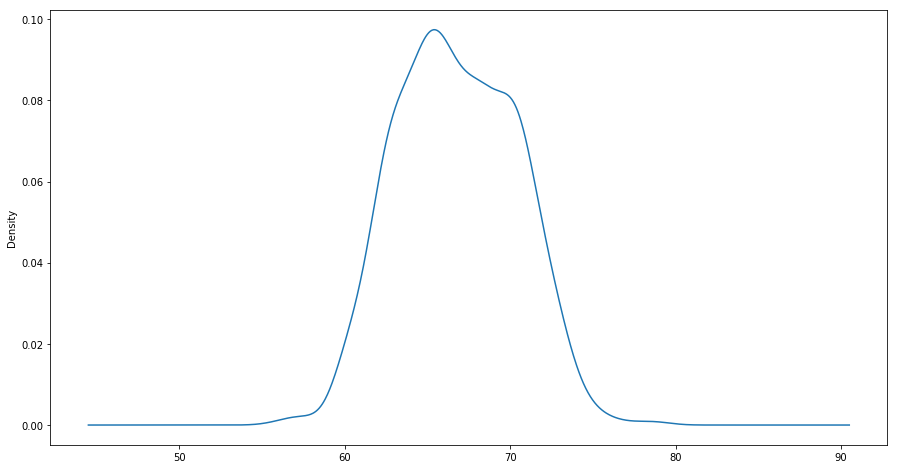

In [6]:
df['Height'].plot.kde()

# Статистический подход

## Z-score

* Посчитать стандартное отклонение. 
* Провести стандартизацию (посчитать z-score каждой точки).
* Те точки, где z-score больше, чем N (например 3, соответствующее 0.13% данных) стандартных отклонений - выбросы

In [7]:
def outliers_z_score(data, threshold):
    x = data.values
    mean_x = np.mean(x)
    print('mean:', mean_x)
    std_x = np.std(x)
    print('std:', std_x)
    print(threshold, '* std:', std_x * threshold)
    z_scores = [(xi - mean_x) / std_x for xi in x]
    
    outliers = x[np.where(np.abs(z_scores) > threshold)]
    
    print('outliers:', outliers)
    ax = data.plot.kde()
    ax.scatter(x, np.zeros(x.shape[0]))
    ax.scatter(outliers, np.zeros(outliers.shape[0]))
    
    for i in range(5):
        left, right = mean_x - i * std_x, mean_x + i * std_x
        ax.plot([right, right], [-.01,0.1], color='red', alpha=0.1)
        ax.plot([left, left], [-.01,0.1], color='red', alpha=0.1)
        
    left, right = mean_x - threshold * std_x, mean_x + threshold * std_x
    print('left, right thresholds:', left, right)
    ax.plot([right, right], [-.01,0.1], color='red', alpha=0.5)
    ax.plot([left, left], [-.01,0.1], color='red', alpha=0.5)

mean: 66.7606904232
std: 3.58092297081
3 * std: 10.7427689124
outliers: [ 78.  79.  56.]
left, right thresholds: 56.0179215107 77.5034593356


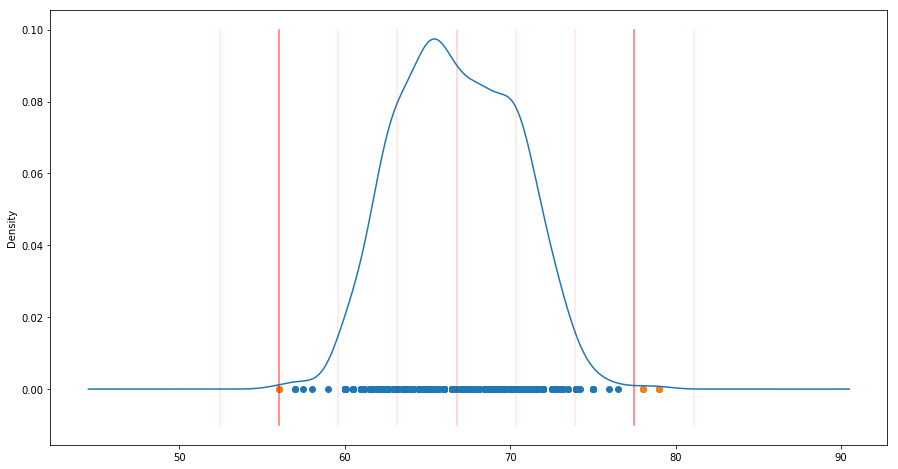

In [8]:
outliers_z_score(df['Height'], threshold=3)

## IQR method

* Рисуем ящик с усами
* коробка - 25 и 75 перцентили, то есть 1 и 3 квартили (первая и третья четверть данных)
* линия внутри коробки - медиана (середина данных, справа и слева от нее одинаковое количество наблюдений)
* считаем ширину коробки - IQR (interquartile range)
* умножаем IQR на 1.5
* все что на 1.5 * IQR дальше от коробки - выбросы

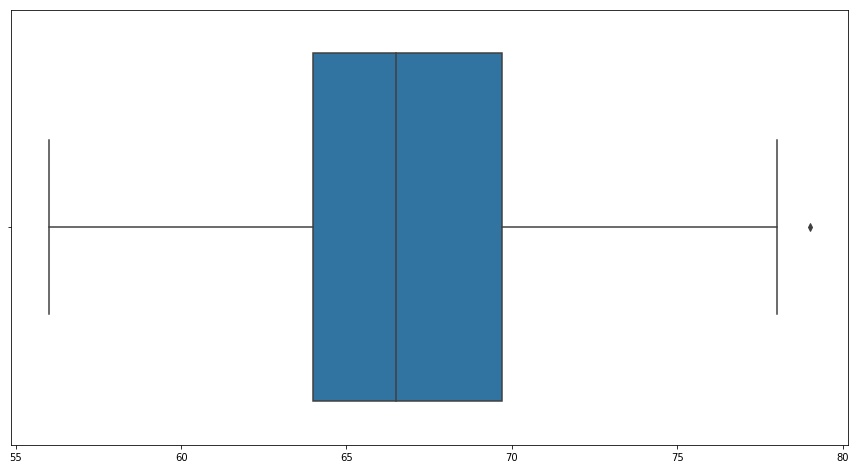

In [9]:
sns.boxplot(x=df['Height'].values)

## Оценка распределения

### Нормальное распределение

$$P(x) = \frac{1}{\sigma \sqrt {2\pi } }e^ { - \frac{\left(x - \mu \right)^2}{ 2\sigma ^2 }}$$

In [10]:
import scipy.stats as stats

def gaussian_estimate(data, threshold):
    
    x = data.values
    loc_param, scale_param = stats.norm.fit(x)
    print(loc_param, scale_param)
    
    xs = np.arange(55, 80, 0.1)
    param_density = stats.norm.pdf(xs, loc=loc_param, scale=scale_param)
    
    ax = data.plot.hist(bins=30, normed=True)
    ax.plot(xs, param_density, color='red')
    ax.plot(xs[np.where(param_density >= threshold)], param_density[np.where(param_density >= threshold)], color='black')
    
    points_new = stats.norm.pdf(x, loc=loc_param, scale=scale_param)
    ax.scatter(x, np.zeros(x.shape[0]) - 0.01, color='black', alpha=0.1)
    points_new_outliers = x[np.where(points_new < threshold)]
    ax.scatter(points_new_outliers, np.zeros(points_new_outliers.shape[0]) - 0.01, color='red')

66.7606904232 3.58092297081


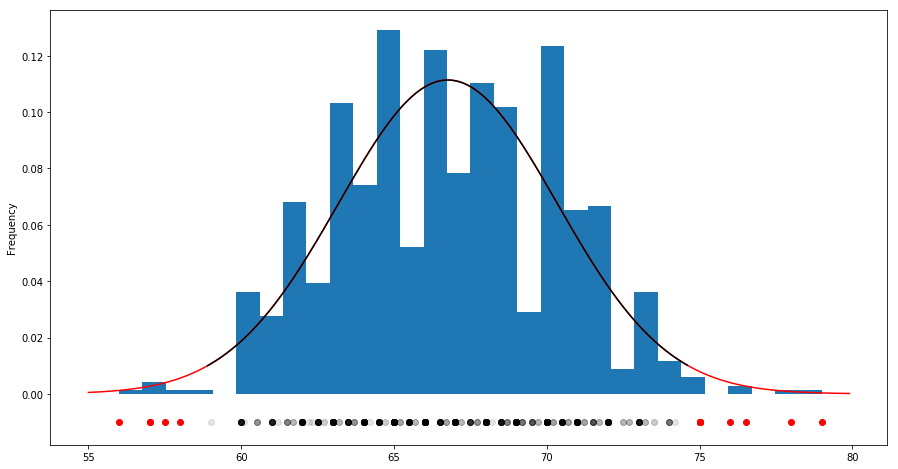

In [11]:
gaussian_estimate(df['Height'], threshold=0.01)

## Многомерные данные

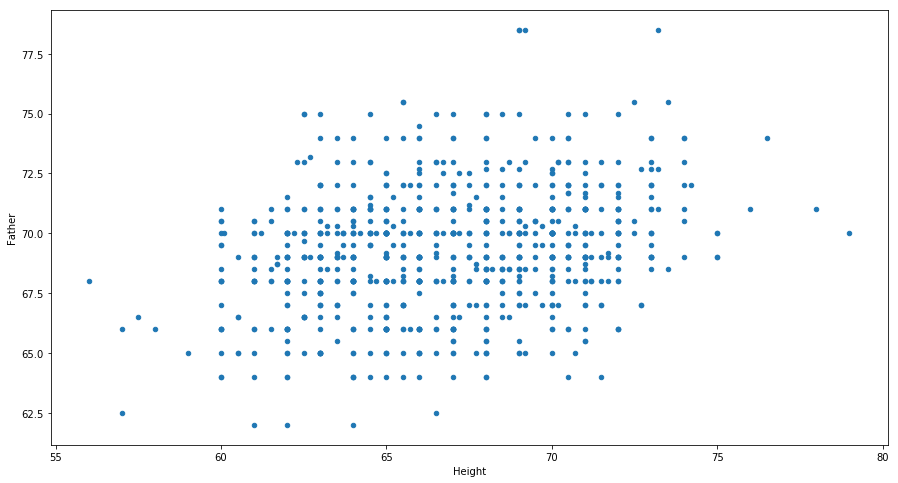

In [12]:
df[['Height', 'Father']].plot.scatter(x='Height', y='Father')

### Многомерное нормальное распределение

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


$\mathbf{\mu} $ - ${D}$-мерный вектор средних


$\mathbf{\Sigma}$ - $D \times D$-мерная матрица ковариации   



In [13]:
import scipy.stats as stats

def gaussian_estimate_dim(data, threshold):
    
    x = data.values
    
    mu = np.mean(x, axis=0)
    sigma = np.cov(x.T)
    print('mu: ', mu)
    print('sigma: ', sigma)
    
    p = stats.multivariate_normal(mean=mu, cov=sigma)
    ax = data.plot.scatter(x='Height', y='Father')
    
    x1, x2 = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(x.min(), x.max(), 100))
    z = p.pdf(np.c_[x1.ravel(), x2.ravel()])
    z = z.reshape(x1.shape)
    cont = ax.contourf(x1, x2, z, cmap=plt.cm.Blues_r, alpha=0.4)
            
    pdf = p.pdf(x)
    outliers = x[np.where(pdf < threshold)]
    ax.scatter(outliers[:, 0], outliers[:, 1], color='red', alpha=0.2)
    print('found outliers: ', outliers.shape[0])

mu:  [ 66.76069042  69.23285078]
sigma:  [[ 12.83730476   2.43708989]
 [  2.43708989   6.10216377]]
found outliers:  512


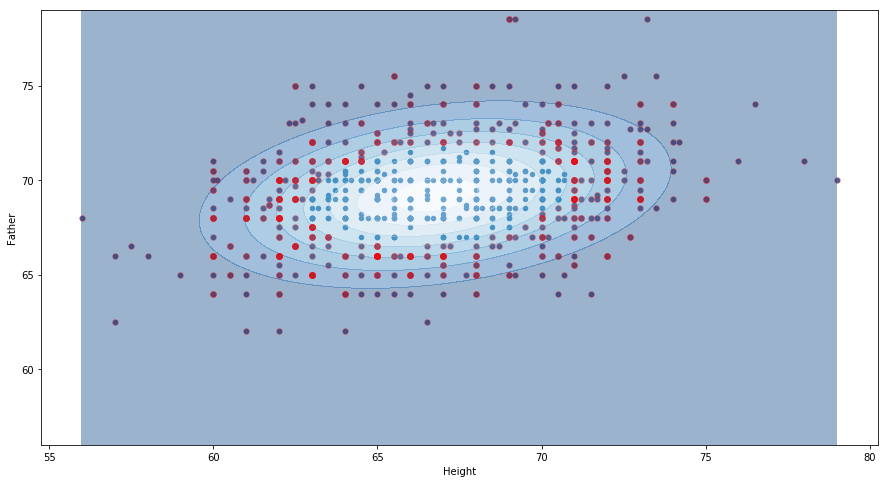

In [14]:
gaussian_estimate_dim(df[['Height', 'Father']], threshold=0.01)

# Подход обучения без учителя

In [15]:
from sklearn.cluster import DBSCAN


def dbscan(data, eps, minPts):
    x = data.values
    
    model = DBSCAN(eps=eps, min_samples=minPts)
    model.fit(x)
    
    labels = model.labels_
    print('labels: ', set(model.labels_))
    plt.scatter(x[:, 0], x[:, 1], c=labels)
    plt.axis('equal')
    plt.show()

labels:  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


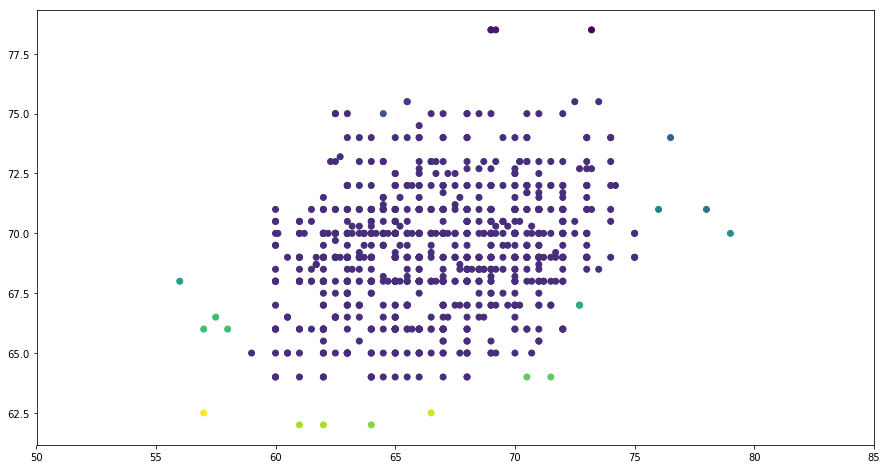

In [16]:
dbscan(df[['Height', 'Father']], eps=1, minPts=0.1)

### Другие варианты
* OPTICS
* k-means. "Нормальные" наблюдения расплолжены близко к центрам кластеров, а аномалии - далеко. После кластеризации итеративно удалять объекты, которые сильнее всего портят критерий алгоритма
* "Нормальные" наблюдения принадлежат большим или плотным кластерам, а аномалии к мелким или разреженым. На основе кластеризации посчитать некоторый скор аномальности, например **Сluster-Based Local Outlier Factor**

### Плотность и расстояние

Будем считать [LOF](https://en.wikipedia.org/wiki/Local_outlier_factor) - Local Outlier Factor.
Для каждого примера измерим локальное отклонение его плотности по сравнению с соседними примерами.

In [17]:
from sklearn.neighbors import LocalOutlierFactor


def lof(data, n_neighbors):
    x = data.values
    
    model = LocalOutlierFactor(n_neighbors=n_neighbors)
    model.fit(x)
    
    labels = abs(model._decision_function(x))
    plt.scatter(x[:, 0], x[:, 1], c=labels)
    
    
    xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(x.min(), x.max(), 100))
    Z = abs(model._decision_function(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    cont = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r, alpha=0.2)
    
    plt.axis('equal')
    plt.show()

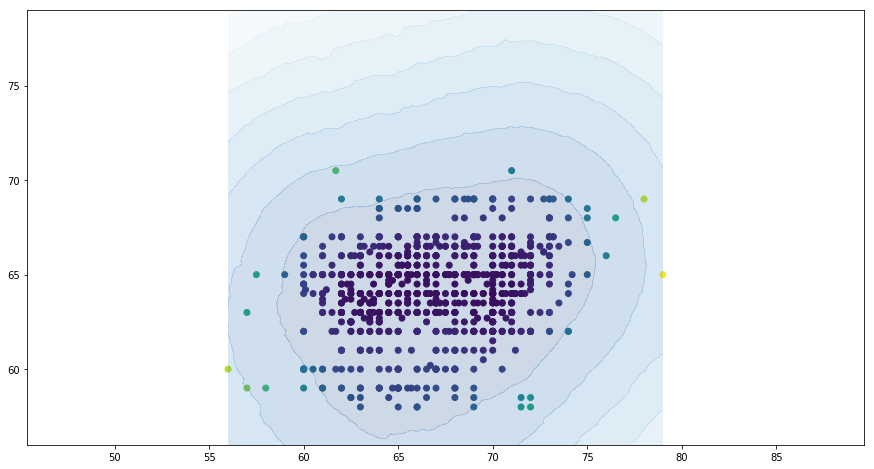

In [18]:
lof(df[['Height', 'Mother']], n_neighbors=100)

### Isolation forest

[IF](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

Строим много деревьев решений.
Каждое дерево строится по алгоритму на случйной подвыборке:
* выбрать случайный признак
* в признаке рассчитать минимум и максимум
* разделить выборку на две части (правое и левое поддерево) выбрав случайное значение между минимумом и максимумом в этом признаке
* делить до тех пор, пока в каждом листе не останется по 1 примеру из выборки

После построения большого количества деревьев для каждого примера выборки посчитать срезний путь от корня до листа. Чем короче путь, тем легче отделить пример от остальной выборки, тем более вероятен выброс.


In [19]:
from sklearn.ensemble import IsolationForest

def iforest(data, trees, samples):
    x = data.values
    
    model = IsolationForest(n_estimators=trees, max_samples=samples)
    model.fit(x)
    
    labels = abs(model.decision_function(x))
    plt.scatter(x[:, 0], x[:, 1], c=labels)

    
    xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(x.min(), x.max(), 100))
    Z = abs(model.decision_function(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    cont = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r, alpha=0.2)
    
    plt.axis('equal')
    plt.show()

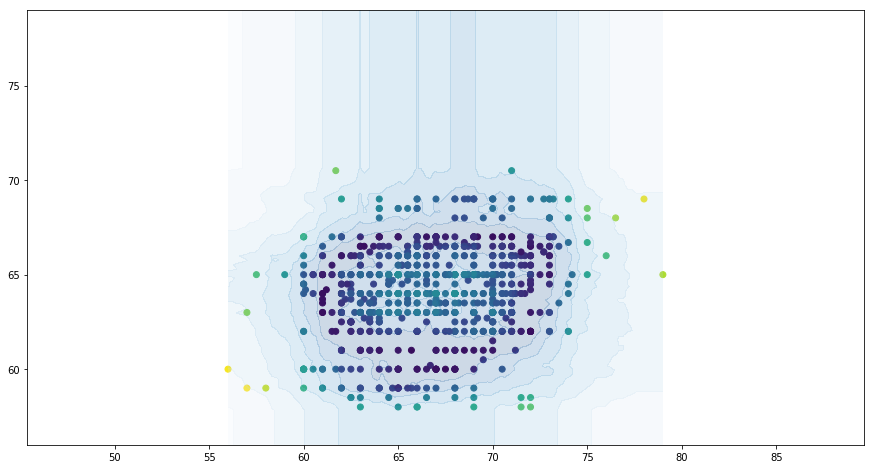

In [20]:
iforest(df[['Height', 'Mother']], trees=100, samples=300)

# С учителем

* Решается обычная задача классификации (нормальный объект/аномалия)
* **Ключевая особенность**: сильный дисбаланс классов

creditcardfraud dataset
https://www.kaggle.com/dalpozz/creditcardfraud

In [21]:
df = pd.read_csv('/media/d_2000/data/fraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [22]:
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

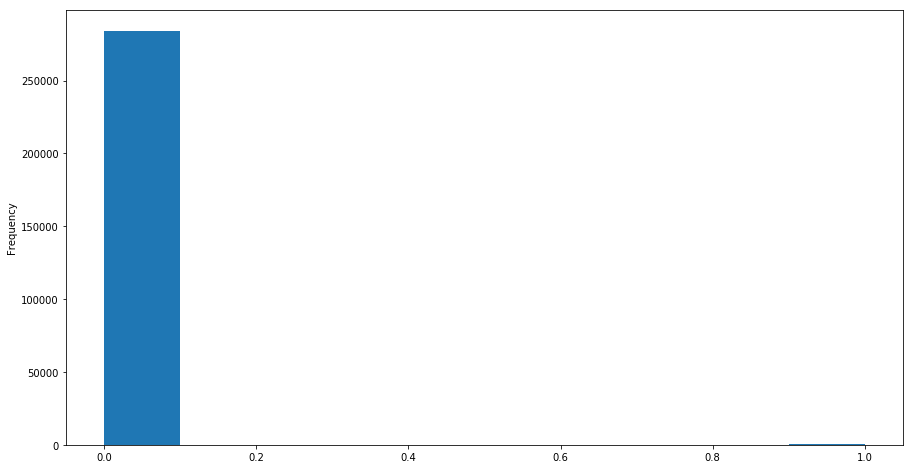

In [23]:
df['Class'].plot.hist()

In [25]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [26]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,0.24,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,-0.34,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,1.16,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,0.14,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,-0.07,0


### Разбиение данных

In [27]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2)

In [28]:
y_train.value_counts()

0    227438
1       407
Name: Class, dtype: int64

In [29]:
y_test.value_counts()

0    56877
1       85
Name: Class, dtype: int64

### Baseline



In [30]:
y = np.zeros(x_train.shape[0])

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). 

In [31]:
from sklearn.metrics import average_precision_score, accuracy_score

In [32]:
accuracy_score(y_train, y)

0.99821369790866599

In [33]:
average_precision_score(y_train, y)

0.0017863020913340209

### Простая логистическая регрессия

In [34]:
from sklearn.linear_model import LogisticRegressionCV

In [35]:
l = LogisticRegressionCV(cv=10)
l.fit(x_train, y_train)
average_precision_score(l.predict(x_train), y_train)

0.51266492948688192

### Взвешивание

* Взвешивание функции потерь
$$ \tilde{L}(X, \theta) = \sum_iw_iL(x_i, \theta) $$
Обычно $w_i$ обратно пропорциональны частоте соответствующего класса

In [36]:
l = LogisticRegressionCV(cv=10, class_weight='balanced')
l.fit(x_train, y_train)
average_precision_score(l.predict(x_train), y_train)


0.093633155297367168

### Under-sampling
Убираем представителей доминирующего класса
* Случайным образом
* Оставить эталонные объекты (ClusterCentroids)
* Оставить объекты, наиболее похожие на представителей минорного класса (NearMiss)
* Удалить объекты, в окрестности которых есть (много) представителей минорного класса (Edited NN, Condenced NN)

In [37]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler, EditedNearestNeighbours, ClusterCentroids, CondensedNearestNeighbour

def imb(sampler, X, y):
    Xs, ys = sampler.fit_sample(X, y)
    model = LogisticRegressionCV(cv=5, class_weight=None).fit(Xs, ys)
    print(average_precision_score(model.predict(X), y))

In [38]:
for s in (
    RandomUnderSampler(), 
#     ClusterCentroids(), 
    EditedNearestNeighbours(), 
#     CondensedNearestNeighbour(),
    NearMiss(version=2)
):
    print(s)
    imb(s, x_train, y_train)

RandomUnderSampler(random_state=None, ratio='auto', replacement=False,
          return_indices=False)
0.0785093074206
EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=3,
            random_state=None, ratio='auto', return_indices=False,
            size_ngh=None)
0.485233054165
NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3, random_state=None,
     ratio='auto', return_indices=False, size_ngh=None, ver3_samp_ngh=None,
     version=2)
0.0843705311877


## Over sampling
Генерируем представителей минорного класса
* Случайным образом из существующих
* Синтетически, на основе существующих


## SMOTE
### Synthetic Minority Over-sampling Technique
* Для каждого представителя минорного класса найте $k$ ближайших соседей
* Выбрать одного из соседей
* Сгенерировать новый объект, расположеный между ними



In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
def imb_over(sampler, X, y):
    Xs, ys = sampler.fit_sample(X, y)
    model = LogisticRegressionCV(cv=5, class_weight=None).fit(Xs, ys)
    print(average_precision_score(model.predict(X), y))

In [ ]:
for s in (
    SMOTE(), 
    RandomOverSampler(), 
):
    print(s)
    imb_over(s, x_train, y_train)

SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)
0.0955036841567
RandomOverSampler(random_state=None, ratio='auto')


In [ ]:
X, y = EditedNearestNeighbours().fit_sample(x_train, y_train)
model = LogisticRegressionCV(cv=5, class_weight=None).fit(X, y)

In [ ]:
print(average_precision_score(model.predict(x_train), y_train))

In [ ]:
print(average_precision_score(model.predict(x_testst), y_test))